In [1]:
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns # Seaborn for better confusion matrix plots

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score # Added metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

2025-05-20 16:51:06.061500: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747759866.511951      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747759866.636552      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# ----- 0. GLOBAL CONSTANTS AND KEYPOINT DEFINITIONS -----

# !!! --- ACTION REQUIRED: REPLACE WITH YOUR ACTUAL 17 KEYPOINT NAMES --- !!!
# รายชื่อ keypoint ทั้ง 17 ชื่อจากไฟล์ CSV
# ลำดับใน list นี้ไม่สำคัญ เพราะจะถูก sort เพื่อสร้าง KEYPOINT_DICT
KEYPOINT_NAMES = [
    'Nose', 'Left Eye', 'Right Eye', 'Left Ear', 'Right Ear',
    'Left Shoulder', 'Right Shoulder', 'Left Elbow', 'Right Elbow',
    'Left Wrist', 'Right Wrist', 'Left Hip', 'Right Hip',
    'Left Knee', 'Right Knee', 'Left Ankle', 'Right Ankle'
] 

# Sort ชื่อ keypoint ตามตัวอักษร (นี่คือลำดับที่ pivot_table ใน generate_fall_sequences.py จะใช้)
SORTED_KEYPOINT_NAMES = sorted(KEYPOINT_NAMES)

# สร้าง KEYPOINT_DICT ที่ถูกต้องตามลำดับการ sort นี้
KEYPOINT_DICT = {name: i for i, name in enumerate(SORTED_KEYPOINT_NAMES)}

# ตั้งค่า NUM_KEYPOINTS จาก KEYPOINT_DICT ที่สร้างขึ้น
NUM_KEYPOINTS = len(KEYPOINT_DICT)

# พิมพ์ออกมาตรวจสอบ
print("--- Initializing Keypoint Definitions ---")
print(f"KEYPOINT_NAMES (before sort): {KEYPOINT_NAMES}")
print(f"SORTED_KEYPOINT_NAMES (used for ordering): {SORTED_KEYPOINT_NAMES}")
print(f"Generated KEYPOINT_DICT: {KEYPOINT_DICT}")
print(f"NUM_KEYPOINTS: {NUM_KEYPOINTS}")

if NUM_KEYPOINTS != 17:
    print(f"WARNING: NUM_KEYPOINTS is {NUM_KEYPOINTS}, but typically expected to be 17 for your case.")
    print("Please double-check the 'KEYPOINT_NAMES' list.")
print("----------------------------------------")

--- Initializing Keypoint Definitions ---
KEYPOINT_NAMES (before sort): ['Nose', 'Left Eye', 'Right Eye', 'Left Ear', 'Right Ear', 'Left Shoulder', 'Right Shoulder', 'Left Elbow', 'Right Elbow', 'Left Wrist', 'Right Wrist', 'Left Hip', 'Right Hip', 'Left Knee', 'Right Knee', 'Left Ankle', 'Right Ankle']
SORTED_KEYPOINT_NAMES (used for ordering): ['Left Ankle', 'Left Ear', 'Left Elbow', 'Left Eye', 'Left Hip', 'Left Knee', 'Left Shoulder', 'Left Wrist', 'Nose', 'Right Ankle', 'Right Ear', 'Right Elbow', 'Right Eye', 'Right Hip', 'Right Knee', 'Right Shoulder', 'Right Wrist']
Generated KEYPOINT_DICT: {'Left Ankle': 0, 'Left Ear': 1, 'Left Elbow': 2, 'Left Eye': 3, 'Left Hip': 4, 'Left Knee': 5, 'Left Shoulder': 6, 'Left Wrist': 7, 'Nose': 8, 'Right Ankle': 9, 'Right Ear': 10, 'Right Elbow': 11, 'Right Eye': 12, 'Right Hip': 13, 'Right Knee': 14, 'Right Shoulder': 15, 'Right Wrist': 16}
NUM_KEYPOINTS: 17
----------------------------------------


In [3]:
# ----- 1. HELPER FUNCTION FOR KEYPOINT INDICES -----
def get_kpt_indices(keypoint_name):
    if keypoint_name not in KEYPOINT_DICT:
        available_keys = list(KEYPOINT_DICT.keys())
        similar_keys = [k for k in available_keys if keypoint_name.lower() in k.lower() or k.lower() in keypoint_name.lower()]
        error_msg = f"Keypoint name '{keypoint_name}' not found in KEYPOINT_DICT. "
        error_msg += f"Available keys are: {available_keys}. "
        if similar_keys: error_msg += f"Did you mean one of these: {similar_keys}? "
        raise ValueError(error_msg)
    kp_idx = KEYPOINT_DICT[keypoint_name]
    return kp_idx * 3, kp_idx * 3 + 1, kp_idx * 3 + 2

In [4]:
# ----- 2. SKELETON NORMALIZATION FUNCTION -----
def normalize_skeleton(sequence_data, min_confidence=0.3):
    normalized_sequence = np.copy(sequence_data)
    ref_kp_names = {
        'ls': 'Left Shoulder', 'rs': 'Right Shoulder',
        'lh': 'Left Hip', 'rh': 'Right Hip'
    }
    for ref_kp_key, ref_kp_name_val in ref_kp_names.items():
        if ref_kp_name_val not in KEYPOINT_DICT:
            print(f"FATAL WARNING in normalize_skeleton: Reference keypoint '{ref_kp_name_val}' (for {ref_kp_key}) "
                  f"is not defined in your KEYPOINT_NAMES / KEYPOINT_DICT. Normalization will likely fail.")

    for t in range(sequence_data.shape[0]):
        frame_data = sequence_data[t, :]
        current_frame_normalized = np.copy(frame_data)
        try:
            ls_x_idx, ls_y_idx, ls_c_idx = get_kpt_indices(ref_kp_names['ls'])
            rs_x_idx, rs_y_idx, rs_c_idx = get_kpt_indices(ref_kp_names['rs'])
            lh_x_idx, lh_y_idx, lh_c_idx = get_kpt_indices(ref_kp_names['lh'])
            rh_x_idx, rh_y_idx, rh_c_idx = get_kpt_indices(ref_kp_names['rh'])
        except ValueError:
            normalized_sequence[t, :] = frame_data; continue

        ls_x, ls_y, ls_c = frame_data[ls_x_idx], frame_data[ls_y_idx], frame_data[ls_c_idx]
        rs_x, rs_y, rs_c = frame_data[rs_x_idx], frame_data[rs_y_idx], frame_data[rs_c_idx]
        lh_x, lh_y, lh_c = frame_data[lh_x_idx], frame_data[lh_y_idx], frame_data[lh_c_idx]
        rh_x, rh_y, rh_c = frame_data[rh_x_idx], frame_data[rh_y_idx], frame_data[rh_c_idx]

        mid_shoulder_x, mid_shoulder_y = np.nan, np.nan
        valid_ls, valid_rs = ls_c > min_confidence, rs_c > min_confidence
        if valid_ls and valid_rs: mid_shoulder_x, mid_shoulder_y = (ls_x + rs_x) / 2, (ls_y + rs_y) / 2
        elif valid_ls: mid_shoulder_x, mid_shoulder_y = ls_x, ls_y
        elif valid_rs: mid_shoulder_x, mid_shoulder_y = rs_x, rs_y

        mid_hip_x, mid_hip_y = np.nan, np.nan
        valid_lh, valid_rh = lh_c > min_confidence, rh_c > min_confidence
        if valid_lh and valid_rh: mid_hip_x, mid_hip_y = (lh_x + rh_x) / 2, (lh_y + rh_y) / 2
        elif valid_lh: mid_hip_x, mid_hip_y = lh_x, lh_y
        elif valid_rh: mid_hip_x, mid_hip_y = rh_x, rh_y

        if np.isnan(mid_hip_x) or np.isnan(mid_hip_y):
            normalized_sequence[t, :] = frame_data; continue

        reference_height = np.nan
        if not np.isnan(mid_shoulder_y) and not np.isnan(mid_hip_y):
            reference_height = np.abs(mid_shoulder_y - mid_hip_y)

        perform_scaling = not (np.isnan(reference_height) or reference_height < 1e-5)

        for kp_i in range(NUM_KEYPOINTS):
            x_i_col, y_i_col = kp_i * 3, kp_i * 3 + 1
            current_frame_normalized[x_i_col] -= mid_hip_x
            current_frame_normalized[y_i_col] -= mid_hip_y
            if perform_scaling:
                current_frame_normalized[x_i_col] /= reference_height
                current_frame_normalized[y_i_col] /= reference_height
        normalized_sequence[t, :] = current_frame_normalized
    return normalized_sequence

In [5]:
# ----- 3. DATA LOADING FUNCTION -----
def load_dataset(data_path, expected_shape_template=(30, None), normalize=True, min_confidence_norm=0.3):
    if NUM_KEYPOINTS is None or NUM_KEYPOINTS == 0:
        raise ValueError("NUM_KEYPOINTS is not set or is zero. Cannot determine expected shape.")
    expected_shape = (expected_shape_template[0], NUM_KEYPOINTS * 3)
    X, y = [], []
    print(f"Loading data from: {data_path}, expecting shape {expected_shape} for .npy files.")
    for label_name, label_val in [('no_fall', 0), ('fall', 1)]:
        folder = os.path.join(data_path, label_name)
        if not os.path.isdir(folder):
            print(f"Warning: Subfolder not found for label '{label_name}': {folder}")
            continue
        files_in_folder = glob(os.path.join(folder, "*.npy"))
        print(f"Found {len(files_in_folder)} .npy files in {folder}")
        loaded_count_for_label = 0
        for file_path in files_in_folder:
            try: arr = np.load(file_path)
            except Exception as e: print(f"Warning: Could not load file {file_path}: {e}"); continue
            if arr.shape == expected_shape:
                if normalize:
                    arr_normalized = normalize_skeleton(arr, min_confidence=min_confidence_norm)
                    if np.isnan(arr_normalized).any():
                        arr_normalized = np.nan_to_num(arr_normalized, nan=0.0, posinf=0.0, neginf=0.0)
                    X.append(arr_normalized)
                else: X.append(arr)
                y.append(label_val)
                loaded_count_for_label += 1
            else: print(f"Warning: Skipping file {file_path} due to incorrect shape: {arr.shape}. Expected: {expected_shape}")
        print(f"Successfully loaded {loaded_count_for_label} samples for label '{label_name}'.")
    if not X:
        print(f"Critical Warning: No data was loaded from {data_path}. Check paths, subfolder names, .npy files, and NUM_KEYPOINTS.")
        return np.array([]), np.array([])
    return np.array(X), np.array(y)


In [6]:
# ----- 4. LSTM MODEL DEFINITION -----
def create_lstm_model(input_shape, lstm_units=64, dense_units=32, dropout_rate=0.5):
    model = Sequential([
        LSTM(lstm_units, input_shape=input_shape, return_sequences=False),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate / 2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [7]:
# Paths 
base_train = '/kaggle/input/fall-dataset6/train'
base_val   = '/kaggle/input/fall-dataset6/val'
base_test  = '/kaggle/input/fall-dataset6/test'

# ----- Parameters -----
TIMESTEPS = 30
EXPECTED_SHAPE_TEMPLATE = (TIMESTEPS, None) # NUM_KEYPOINTS will be used in load_dataset
MIN_CONF_NORM = 0.2

# Load Datasets
print("\n--- Loading Training Data ---")
X_train_orig, y_train_orig = load_dataset(base_train, expected_shape_template=EXPECTED_SHAPE_TEMPLATE, normalize=True, min_confidence_norm=MIN_CONF_NORM)
print("\n--- Loading Validation Data ---")
X_val_orig, y_val_orig = load_dataset(base_val, expected_shape_template=EXPECTED_SHAPE_TEMPLATE, normalize=True, min_confidence_norm=MIN_CONF_NORM)
print("\n--- Loading Test Data ---")
X_test_orig, y_test_orig = load_dataset(base_test, expected_shape_template=EXPECTED_SHAPE_TEMPLATE, normalize=True, min_confidence_norm=MIN_CONF_NORM)

if X_train_orig.size == 0:
    print("FATAL ERROR: Training data is empty.")
    

# print shapes และ lstm_input_shape
print(f"\nShapes after loading:")
print(f"Train: X={X_train_orig.shape if X_train_orig.size > 0 else 'Empty'}, y={y_train_orig.shape if y_train_orig.size > 0 else 'Empty'}")
print(f"Val:   X={X_val_orig.shape if X_val_orig.size > 0 else 'Empty'}, y={y_val_orig.shape if y_val_orig.size > 0 else 'Empty'}")
print(f"Test:  X={X_test_orig.shape if X_test_orig.size > 0 else 'Empty'}, y={y_test_orig.shape if y_test_orig.size > 0 else 'Empty'}")

lstm_input_shape = (TIMESTEPS, NUM_KEYPOINTS * 3)
print(f"\nLSTM Input Shape: {lstm_input_shape}")


--- Loading Training Data ---
Loading data from: /kaggle/input/fall-dataset6/train, expecting shape (30, 51) for .npy files.
Found 6279 .npy files in /kaggle/input/fall-dataset6/train/no_fall
Successfully loaded 6279 samples for label 'no_fall'.
Found 5722 .npy files in /kaggle/input/fall-dataset6/train/fall
Successfully loaded 5722 samples for label 'fall'.

--- Loading Validation Data ---
Loading data from: /kaggle/input/fall-dataset6/val, expecting shape (30, 51) for .npy files.
Found 1346 .npy files in /kaggle/input/fall-dataset6/val/no_fall
Successfully loaded 1346 samples for label 'no_fall'.
Found 1226 .npy files in /kaggle/input/fall-dataset6/val/fall
Successfully loaded 1226 samples for label 'fall'.

--- Loading Test Data ---
Loading data from: /kaggle/input/fall-dataset6/test, expecting shape (30, 51) for .npy files.
Found 1346 .npy files in /kaggle/input/fall-dataset6/test/no_fall
Successfully loaded 1346 samples for label 'no_fall'.
Found 1226 .npy files in /kaggle/input/

In [8]:
# ----- Cross-Validation -----
N_SPLITS_CV = 5
EPOCHS_CV = 30
BATCH_SIZE_CV = 32
cv_accuracies, cv_losses = [], []
fold_no = 1

print(f"\n--- Starting {N_SPLITS_CV}-Fold Cross-Validation ---")
if X_train_orig.size > 0 and y_train_orig.size >= N_SPLITS_CV :
    skf = StratifiedKFold(n_splits=N_SPLITS_CV, shuffle=True, random_state=42)
    for train_idx, val_idx in skf.split(X_train_orig, y_train_orig):
        print(f"--- Fold {fold_no}/{N_SPLITS_CV} ---")
        X_cv_train, X_cv_val = X_train_orig[train_idx], X_train_orig[val_idx]
        y_cv_train, y_cv_val = y_train_orig[train_idx], y_train_orig[val_idx]
        cv_model = create_lstm_model(lstm_input_shape)
        # early_stopping_cv = EarlyStopping(monitor='val_accuracy', patience=7, verbose=1, mode='max', restore_best_weights=True)
        history_cv = cv_model.fit(X_cv_train, y_cv_train, epochs=EPOCHS_CV, batch_size=BATCH_SIZE_CV, validation_data=(X_cv_val, y_cv_val), verbose=1) # callbacks=[early_stopping_cv]
        loss, accuracy = cv_model.evaluate(X_cv_val, y_cv_val, verbose=0)
        print(f"Fold {fold_no} - CV Val Loss: {loss:.4f}, CV Val Accuracy: {accuracy:.4f}")
        cv_losses.append(loss); cv_accuracies.append(accuracy)
        fold_no += 1
    if cv_accuracies:
        print("\n--- Cross-Validation Summary ---")
        print(f"Average CV Loss: {np.mean(cv_losses):.4f} (+/- {np.std(cv_losses):.4f})")
        print(f"Average CV Accuracy: {np.mean(cv_accuracies):.4f} (+/- {np.std(cv_accuracies):.4f})")
    else: print("Cross-validation did not produce results (or was skipped).")
else:
    print(f"Skipping Cross-Validation: Training data is empty or has too few samples ({y_train_orig.size}) for {N_SPLITS_CV} splits.")


--- Starting 5-Fold Cross-Validation ---
--- Fold 1/5 ---


I0000 00:00:1747760177.968154      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747760177.968847      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30


I0000 00:00:1747760183.089449     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7020 - loss: 0.5793 - val_accuracy: 0.7701 - val_loss: 0.4742
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7542 - loss: 0.5041 - val_accuracy: 0.8001 - val_loss: 0.4310
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7746 - loss: 0.4722 - val_accuracy: 0.8163 - val_loss: 0.4093
Epoch 4/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7962 - loss: 0.4456 - val_accuracy: 0.8209 - val_loss: 0.4090
Epoch 5/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8162 - loss: 0.4256 - val_accuracy: 0.8305 - val_loss: 0.3780
Epoch 6/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8336 - loss: 0.3841 - val_accuracy: 0.8421 - val_loss: 0.3679
Epoch 7/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8293 - loss: 0.3872 - val_accuracy: 0.8426 - val_loss: 0.3681
Epoch 8/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8319 - loss: 0.3783 - val_accuracy: 0.8430 - val_

In [9]:
# ----- Train Final Model -----
EPOCHS_FINAL = 30 
BATCH_SIZE_FINAL = 32
final_model = None
history_final = None # Initialize history_final

if X_train_orig.size > 0:
    print("\n--- Training Final Model ---")
    final_model = create_lstm_model(lstm_input_shape)
    callbacks_final = []
    validation_data_final = None
    if X_val_orig.size > 0 and y_val_orig.size > 0:
        validation_data_final = (X_val_orig, y_val_orig)
        early_stopping_final = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='max', restore_best_weights=True)
        callbacks_final.append(early_stopping_final)
        print(f"Training final model with validation data (shape: {X_val_orig.shape}) and EarlyStopping.")
    else:
        print("Training final model without validation data. EarlyStopping on val_accuracy disabled.")
    history_final = final_model.fit(X_train_orig, y_train_orig, epochs=EPOCHS_FINAL, batch_size=BATCH_SIZE_FINAL, validation_data=validation_data_final, callbacks=callbacks_final if callbacks_final else None, verbose=1)


--- Training Final Model ---
Training final model with validation data (shape: (2572, 30, 51)) and EarlyStopping.
Epoch 1/30
376/376 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7047 - loss: 0.5747 - val_accuracy: 0.7912 - val_loss: 0.4518
Epoch 2/30
376/376 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7535 - loss: 0.5121 - val_accuracy: 0.8149 - val_loss: 0.4099
Epoch 3/30
376/376 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7969 - loss: 0.4510 - val_accuracy: 0.8320 - val_loss: 0.3826
Epoch 4/30
376/376 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8121 - loss: 0.4223 - val_accuracy: 0.8383 - val_loss: 0.3786
Epoch 5/30
376/376 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8208 - loss: 0.4078 - val_accuracy: 0.8476 - val_loss: 0.3493
Epoch 6/30
376/376 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8380 - loss: 0.3769 - val_accuracy: 0.8495 - val_loss: 0.3527
Epoch 7/30
376/376 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8484 - loss: 0.3599 - val_accuracy: 0.8558 - val_lo

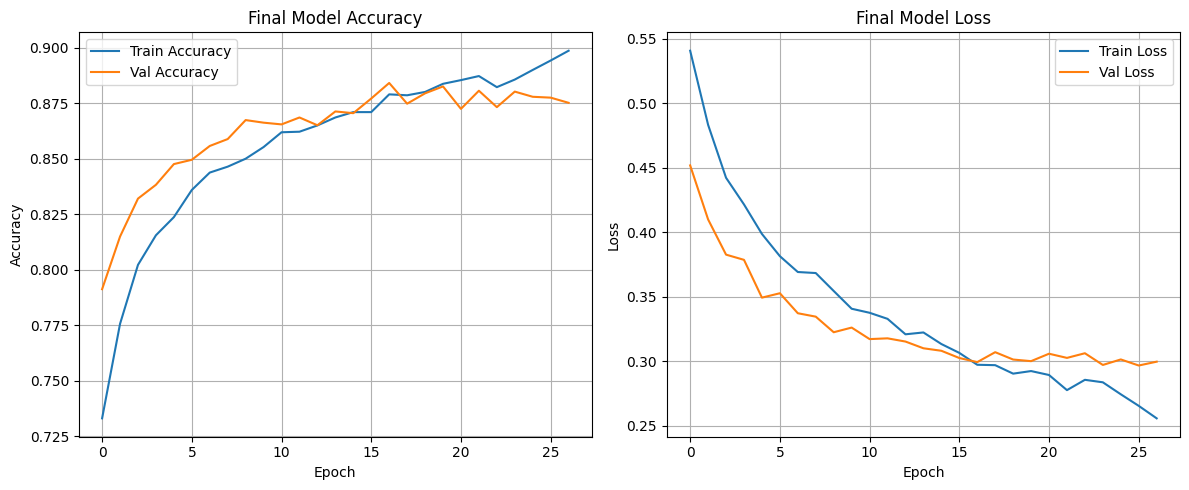


--- Script Finished ---


In [10]:
# ----- Plot Training History of Final Model -----

if history_final and hasattr(history_final, 'history') and history_final.history:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    if 'accuracy' in history_final.history: plt.plot(history_final.history['accuracy'], label='Train Accuracy')
    if 'val_accuracy' in history_final.history: plt.plot(history_final.history['val_accuracy'], label='Val Accuracy')
    plt.title('Final Model Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)
    plt.subplot(1, 2, 2)
    if 'loss' in history_final.history: plt.plot(history_final.history['loss'], label='Train Loss')
    if 'val_loss' in history_final.history: plt.plot(history_final.history['val_loss'], label='Val Loss')
    plt.title('Final Model Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
    plt.tight_layout(); plt.show()
else:
    print("Skipping plotting of training history as final model training was not completed or history is unavailable.")

print("\n--- Script Finished ---")

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score, precision_recall_fscore_support

# ----- FUNCTION TO PLOT CONFUSION MATRIX -----
def plot_confusion_matrix_custom(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# ----- FUNCTION TO PLOT METRICS BARCHART  -----
def plot_metrics_barchart(metrics_data, class_names, title='Metrics per Class'):
    """
    Plots a grouped bar chart for precision, recall, f1-score, f2-score for each class.
    metrics_data should be a dictionary like:
    {
        'Precision': [precision_class0, precision_class1],
        'Recall': [recall_class0, recall_class1],
        'F1-score': [f1_class0, f1_class1],
        'F2-score': [f2_class0, f2_class1]
    }
    """
    df_metrics = pd.DataFrame(metrics_data, index=class_names)
    
    ax = df_metrics.plot(kind='bar', figsize=(10, 7), width=0.8, colormap='viridis') # You can change colormap
    plt.title(title, fontsize=15)
    plt.ylabel('Score (%)', fontsize=12)
    plt.xlabel('Class', fontsize=12)
    plt.xticks(rotation=0)
    plt.ylim(0, 1) # Scores are between 0 and 1, display as 0-100 if multiplied by 100 before
    
    # Add text annotations to the bars
    for p in ax.patches:
        ax.annotate(f"{p.get_height()*100:.1f}%", # Format as percentage
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points',
                    fontsize=10)
    
    plt.legend(title='Metrics')
    plt.tight_layout()
    plt.show()



--- Custom Validation Metrics Report ---
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
           Precision     Recall   F1-score   F2-score    Support
no_fall       0.9081     0.8663     0.8867     0.8743       1346
fall          0.8602     0.9038     0.8815     0.8947       1226


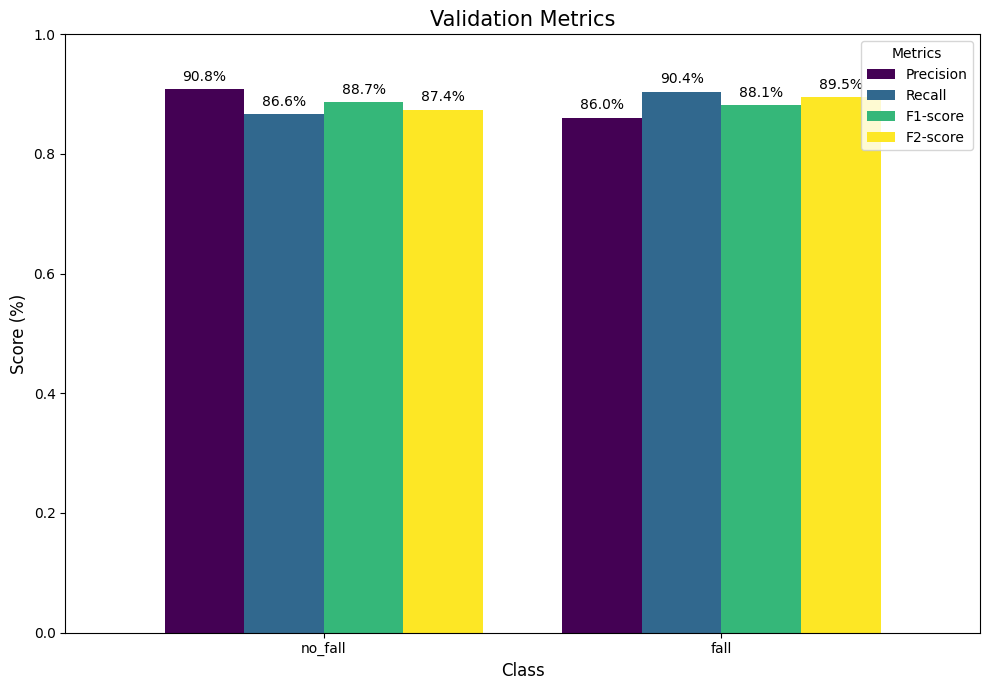

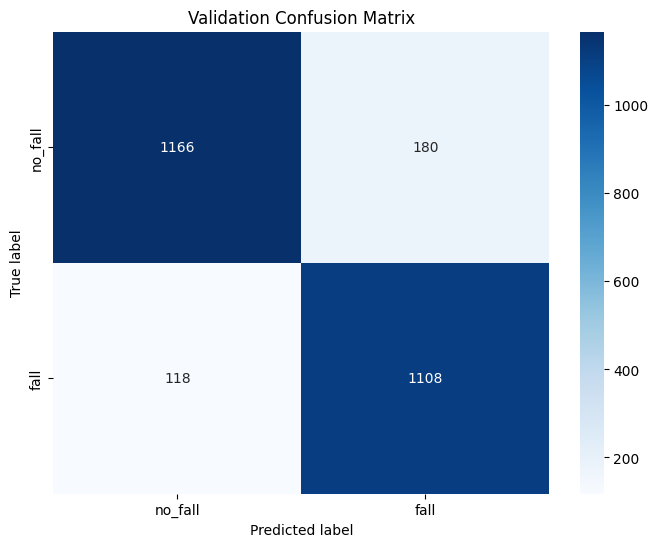



--- Custom Test Metrics Report ---
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
           Precision     Recall   F1-score   F2-score    Support
no_fall       0.8940     0.8588     0.8761     0.8657       1346
fall          0.8514     0.8883     0.8695     0.8806       1226


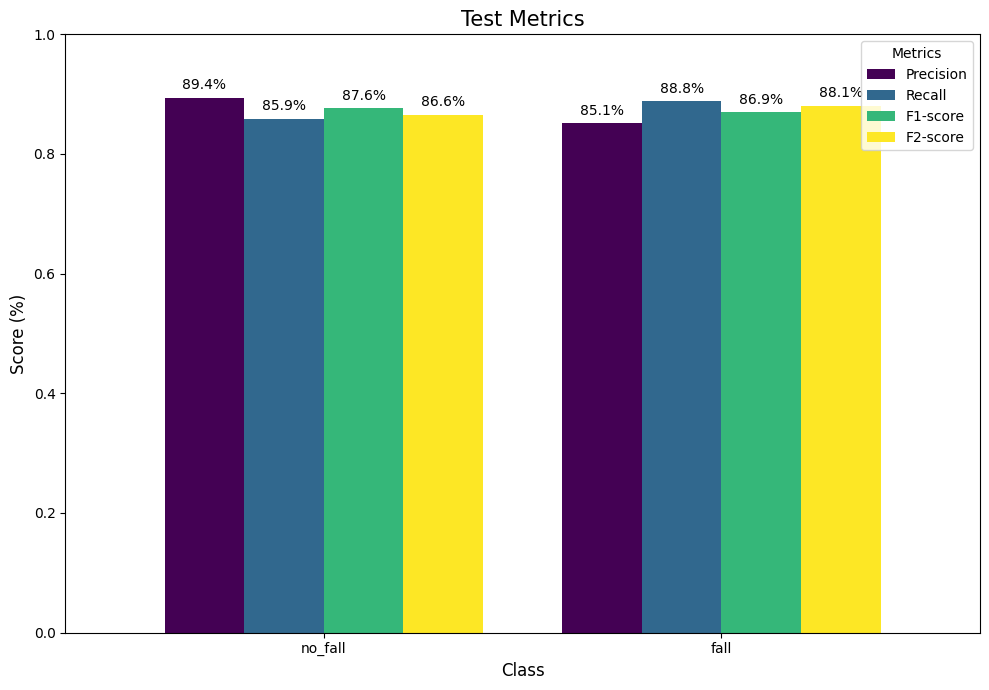

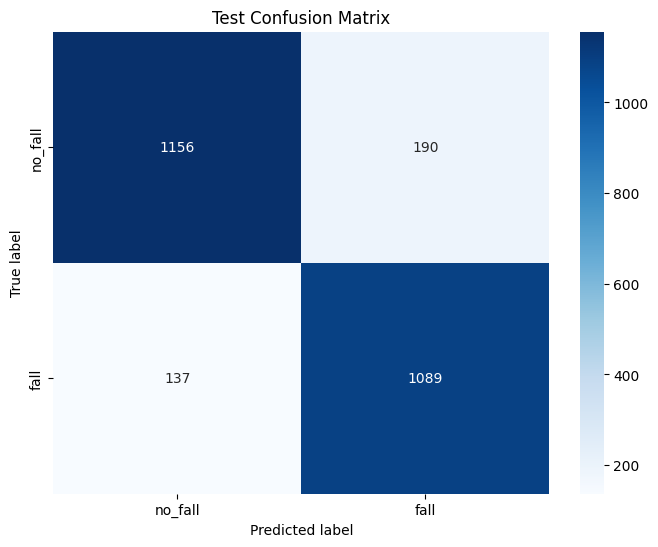

In [15]:
import pandas as pd

# ----- DETAILED EVALUATION AND REPORTING -----
target_names = ['no_fall', 'fall'] # สำหรับ classification report
class_labels = [0, 1] # Corresponding numerical labels

if final_model is not None: # ตรวจสอบว่า final_model ถูกสร้างและเทรนแล้ว
    # --- Evaluation on Validation Set ---
    if X_val_orig.size > 0 and y_val_orig.size > 0:
        print("\n\n--- Custom Validation Metrics Report ---")
        y_pred_val_probs = final_model.predict(X_val_orig)
        y_pred_val_classes = (y_pred_val_probs > 0.5).astype(int).flatten()

        # Calculate metrics per class
        precision_val, recall_val, f1_val, support_val = precision_recall_fscore_support(
            y_val_orig, y_pred_val_classes, labels=class_labels, zero_division=0
        )
        f2_val_per_class = fbeta_score(y_val_orig, y_pred_val_classes, beta=2, labels=class_labels, average=None, zero_division=0)

        print(f"{'':9} {'Precision':>10} {'Recall':>10} {'F1-score':>10} {'F2-score':>10} {'Support':>10}")
        for i, class_name in enumerate(target_names):
            print(f"{class_name:9} {precision_val[i]:>10.4f} {recall_val[i]:>10.4f} {f1_val[i]:>10.4f} {f2_val_per_class[i]:>10.4f} {support_val[i]:>10}")
        
        # For plotting (scores between 0 and 1)
        val_metrics_for_plot = {
            'Precision': precision_val,
            'Recall': recall_val,
            'F1-score': f1_val,
            'F2-score': f2_val_per_class
        }
        plot_metrics_barchart(val_metrics_for_plot, target_names, title='Validation Metrics')

        # Confusion Matrix
        cm_val = confusion_matrix(y_val_orig, y_pred_val_classes, labels=class_labels)
        plot_confusion_matrix_custom(cm_val, classes=target_names, title='Validation Confusion Matrix')
    else:
        print("\nValidation data is empty. Skipping detailed validation metrics report.")

    # --- Evaluation on Test Set ---
    if X_test_orig.size > 0 and y_test_orig.size > 0:
        print("\n\n--- Custom Test Metrics Report ---")
        y_pred_test_probs = final_model.predict(X_test_orig)
        y_pred_test_classes = (y_pred_test_probs > 0.5).astype(int).flatten()

        # Calculate metrics per class
        precision_test, recall_test, f1_test, support_test = precision_recall_fscore_support(
            y_test_orig, y_pred_test_classes, labels=class_labels, zero_division=0
        )
        f2_test_per_class = fbeta_score(y_test_orig, y_pred_test_classes, beta=2, labels=class_labels, average=None, zero_division=0)

        print(f"{'':9} {'Precision':>10} {'Recall':>10} {'F1-score':>10} {'F2-score':>10} {'Support':>10}")
        for i, class_name in enumerate(target_names):
            print(f"{class_name:9} {precision_test[i]:>10.4f} {recall_test[i]:>10.4f} {f1_test[i]:>10.4f} {f2_test_per_class[i]:>10.4f} {support_test[i]:>10}")

        # For plotting
        test_metrics_for_plot = {
            'Precision': precision_test,
            'Recall': recall_test,
            'F1-score': f1_test,
            'F2-score': f2_test_per_class
        }
        plot_metrics_barchart(test_metrics_for_plot, target_names, title='Test Metrics')
        
        # Confusion Matrix
        cm_test = confusion_matrix(y_test_orig, y_pred_test_classes, labels=class_labels)
        plot_confusion_matrix_custom(cm_test, classes=target_names, title='Test Confusion Matrix')
    else:
        print("\nTest data is empty. Skipping detailed test metrics report.")
else:
    print("Final model was not trained (likely due to empty training data). Skipping detailed evaluation.")